In [1]:
import os
import sys
import json
import datetime

import pandas as pd
import numpy as np

In [2]:
cwd = os.getcwd()
join = os.path.join
norm = os.path.normpath

In [3]:
sys.path.append(norm(join(cwd, '..', '..', '..', 'glhe')))

In [4]:
from standalone.plant_loop import PlantLoop
import glhe

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15, 9]
plt.rcParams['font.size'] = 14

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [7]:
d = glhe.globals.functions.load_json('EWT_MFRTRT_input.json')
d['ground-heat-exchanger'][0]['g-function-path'] = join(cwd, 'EWT_experimental_g_functions.csv')
d['ground-heat-exchanger'][0]['load-aggregation']['method'] = 'dynamic'
d['simulation']['time-steps-per-hour'] = 60
d['simulation']['runtime'] = 3600 * 48

In [8]:
with open(join(cwd, 'in.json'), 'w') as f:
    f.write(json.dumps(d, sort_keys=True, indent=2, separators=(',', ': ')))

In [9]:
PlantLoop('in.json').simulate()

True

In [10]:
df = pd.read_csv('out.csv', index_col='Date/Time', parse_dates=True)

In [11]:
h = d['borehole-definitions'][0]['depth']
alpha = d['soil']['conductivity'] / (d['soil']['density'] * d['soil']['specific-heat'])
ts = h**2 / (9*alpha)

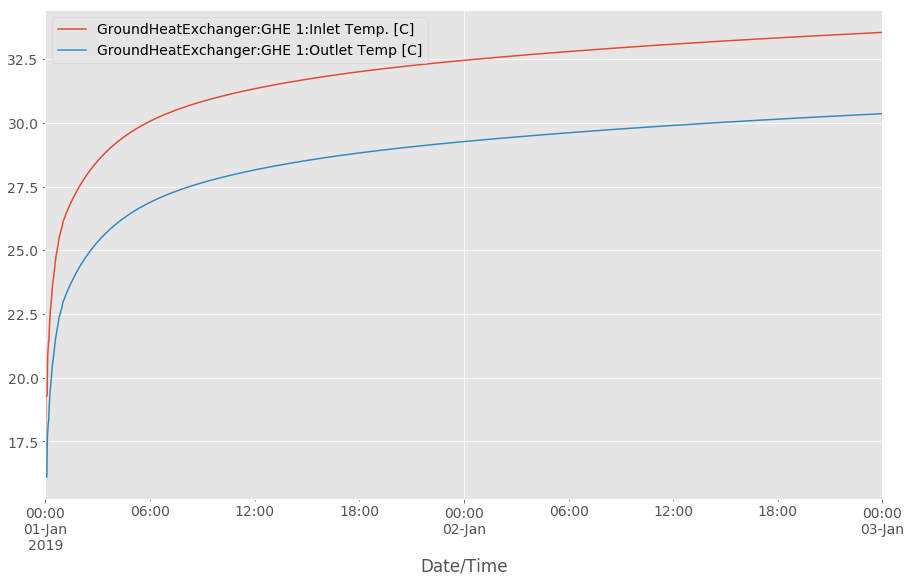

In [12]:
df[['GroundHeatExchanger:GHE 1:Inlet Temp. [C]',
   'GroundHeatExchanger:GHE 1:Outlet Temp [C]']].plot(grid=True)

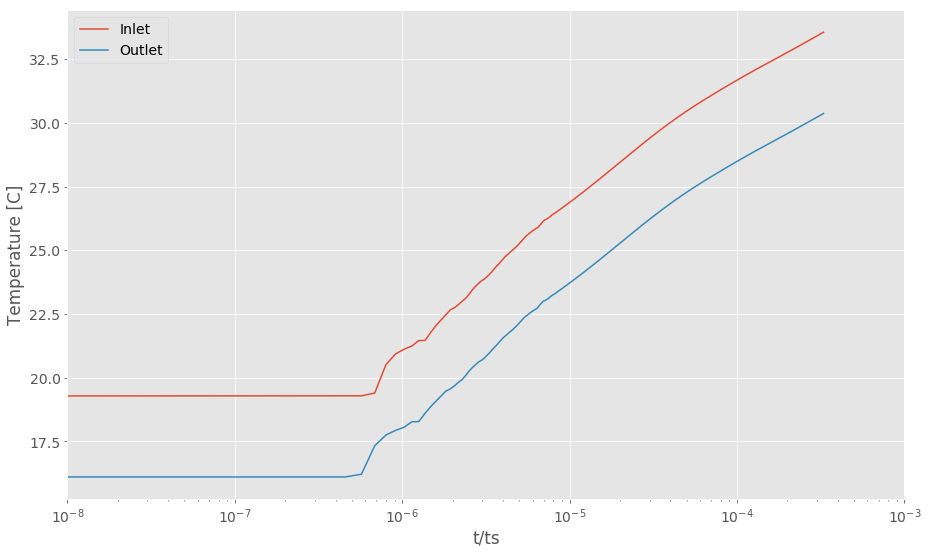

In [13]:
plt.semilogx(df['Elapsed Time [s]'].values / ts, df['GroundHeatExchanger:GHE 1:Inlet Temp. [C]'].values, label='Inlet')
plt.semilogx(df['Elapsed Time [s]'].values / ts, df['GroundHeatExchanger:GHE 1:Outlet Temp [C]'].values, label='Outlet')
plt.ylabel('Temperature [C]')
plt.xlabel('t/ts')
plt.xlim(1e-8, 1e-3)
plt.legend()
plt.show()

In [14]:
data_path = norm(join(cwd, '..', '..', 'validation', 'MFRTRT', 'MFRTRT_loads.csv'))
df_raw_data = pd.read_csv(data_path, parse_dates=True, index_col='Date/Time')

In [15]:
df_raw_data.head(1)

,AC Voltage [VAC],DC Voltage [VDC],Flow Meter [GPM],Air Temp [C],Inlet 1 [C],Outlet 1 [C],Inlet 2 [C],Outlet 2 [C],Base Heater [W},Var. Heater [W],...,Inst. HT [2] [W],Meas. Total Power [W],Est. Pump Power [W],Inlet [1] - Inlet [2] [C],Outlet [1] - Outlet [2] [C],Bits,FFP,DT [1] - DT [2] [C],MFT [1] [C],MFT [2] [C]
Date/Time,,,,,,,,,,,,,,,,,,,,,
2013-12-20 12:05:54,0.135911,0.002987,4.655363,12.483983,16.074835,16.107059,16.069417,16.163488,99.1085,76.4628,...,115.514676,389.281862,213.710562,0.005418,-0.056429,78.94109,0.419335,-0.061847,16.090947,16.088238


In [16]:
df_raw_data.columns

Index(['AC Voltage [VAC]', 'DC Voltage [VDC]', 'Flow Meter [GPM]',
       'Air Temp [C]', 'Inlet 1 [C]', 'Outlet 1 [C]', 'Inlet 2 [C]',
       'Outlet 2 [C]', 'Base Heater [W}', 'Var. Heater [W]', 'Pump Watts [W]',
       'Pump Volts [VAC]', 'Pump Amps [Amps]', 'SCR Output [VDC]',
       'Calc Pump Power [W]', 'Flow [L/s]', 'mdot [kg/s]', 'cp [J/kg-K]',
       'Inst. HT [1] [W]', 'Inst. HT [2] [W]', 'Meas. Total Power [W]',
       'Est. Pump Power [W]', 'Inlet [1] - Inlet [2] [C]',
       'Outlet [1] - Outlet [2] [C]', 'Bits', 'FFP', 'DT [1] - DT [2] [C]',
       'MFT [1] [C]', 'MFT [2] [C]'],
      dtype='object')

In [17]:
df_sim_input_data = df_raw_data[['Inst. HT [1] [W]', 'mdot [kg/s]', 'Outlet 1 [C]', 'Inlet 1 [C]']].copy(deep=True)
df_sim_input_data.rename(columns = {'Inst. HT [1] [W]': 'HT Rate [W]', 
                                    'Outlet 1 [C]': 'Exp. Inlet [C]', 
                                    'Inlet 1 [C]': 'Exp. Outlet [C]'}, inplace=True)
df_sim_input_data.resample('1T').mean()
df_sim_input_data.to_csv(join(cwd, 'input_data.csv'))
df_sim_input_data.head(1)

,HT Rate [W],mdot [kg/s],Exp. Inlet [C],Exp. Outlet [C]
Date/Time,,,,
2013-12-20 12:05:54,39.569556,0.293393,16.107059,16.074835


In [18]:
d['temperature-profile'] = [{'name': 'EWT Data', 
                             'temperature-profile-type': 'external',
                             'path': join(cwd, 'input_data.csv')}]

d['flow-profile'][0] = {'name': 'EWT Data', 
                        'flow-profile-type': 'external',
                        'path': join(cwd, 'input_data.csv')}

d['topology']['demand-side'][0] = {'comp-type': 'flow-profile',
                                   'name': 'EWT Data'}

d['topology']['demand-side'][1] = {'comp-type': 'temperature-profile',
                                   'name': 'EWT Data'}

In [19]:
with open(join(cwd, 'in.json'), 'w') as f:
    f.write(json.dumps(d, sort_keys=True, indent=2, separators=(',', ': ')))

In [20]:
PlantLoop('in.json').simulate()

True

In [21]:
df = pd.read_csv('out.csv', index_col='Date/Time', parse_dates=True)

In [22]:
df.columns

Index(['Elapsed Time [s]', 'ExternalFlow:EWT DATA:Flow Rate [kg/s]',
       'ExternalTemps:EWT DATA:Outlet Temp [C]',
       'GroundHeatExchanger:GHE 1:Heat Rate [W]',
       'GroundHeatExchanger:GHE 1:Inlet Temp. [C]',
       'GroundHeatExchanger:GHE 1:Outlet Temp [C]',
       'PlantLoop:Demand Inlet Temp. [C]', 'PlantLoop:Demand Outlet Temp. [C]',
       'PlantLoop:Supply Inlet Temp. [C]',
       'PlantLoop:Supply Outlet Temp. [C]'],
      dtype='object')

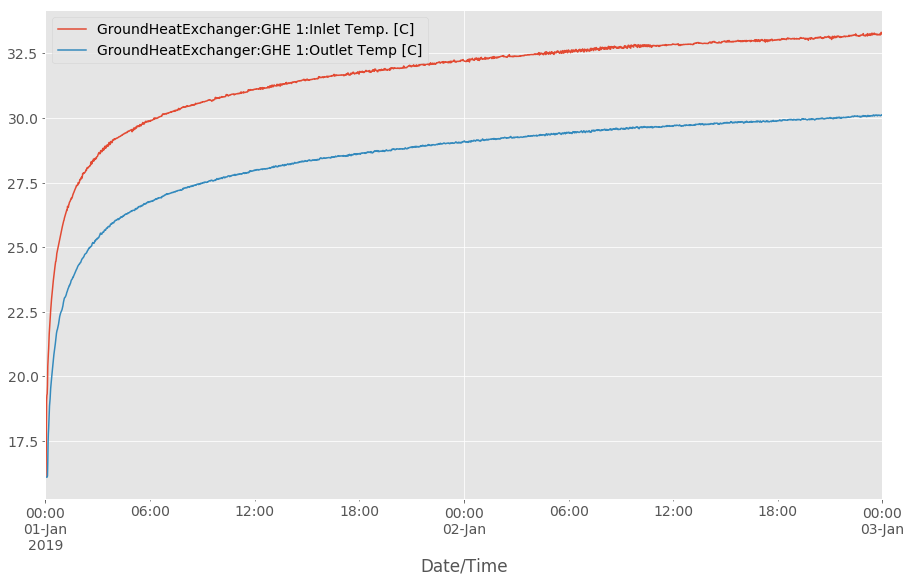

In [23]:
df[['GroundHeatExchanger:GHE 1:Inlet Temp. [C]',
   'GroundHeatExchanger:GHE 1:Outlet Temp [C]']].plot(grid=True)

In [24]:
df_sim_input_data['time'] = pd.to_timedelta(df_sim_input_data.index)
df_sim_input_data['time'] = datetime.datetime(year=2019, month=1, day=1, hour=0, minute=0) + (df_sim_input_data['time'] - df_sim_input_data['time'][0])
df_sim_input_data.set_index('time', inplace=True)
df_sim_input_data.index.rename('Date/Time', inplace=True)
df_sim_input_data.head(1)

/Users/mattmitchell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  """Entry point for launching an IPython kernel.


,HT Rate [W],mdot [kg/s],Exp. Inlet [C],Exp. Outlet [C]
Date/Time,,,,
2019-01-01,39.569556,0.293393,16.107059,16.074835


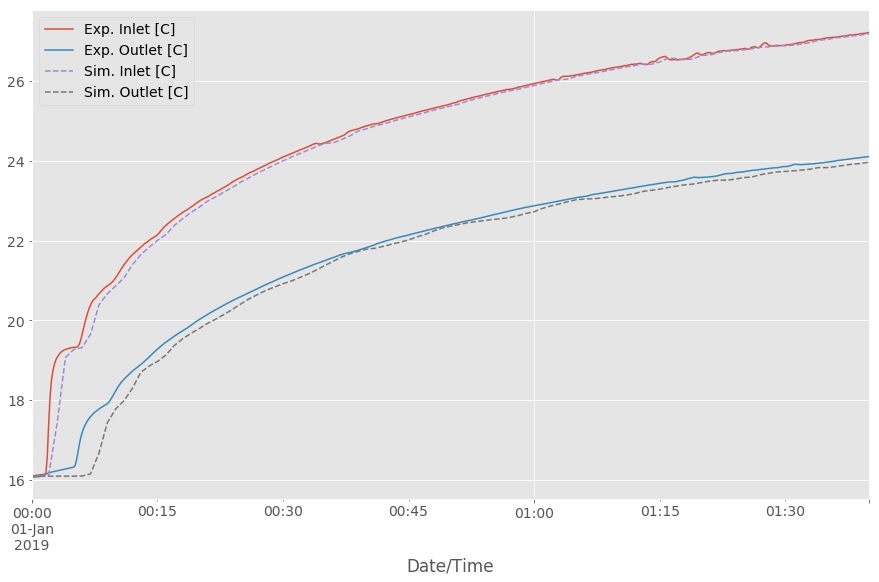

In [28]:
ax = df_sim_input_data[['Exp. Inlet [C]', 'Exp. Outlet [C]']].loc[df.index[0] : df.index[100]].plot()
df[['GroundHeatExchanger:GHE 1:Inlet Temp. [C]',
    'GroundHeatExchanger:GHE 1:Outlet Temp [C]']].loc[df.index[0] : df.index[100]].rename(columns = {'GroundHeatExchanger:GHE 1:Inlet Temp. [C]': 'Sim. Inlet [C]',
                                                                    'GroundHeatExchanger:GHE 1:Outlet Temp [C]': 'Sim. Outlet [C]'}).plot(grid=True, ax=ax, style='--')

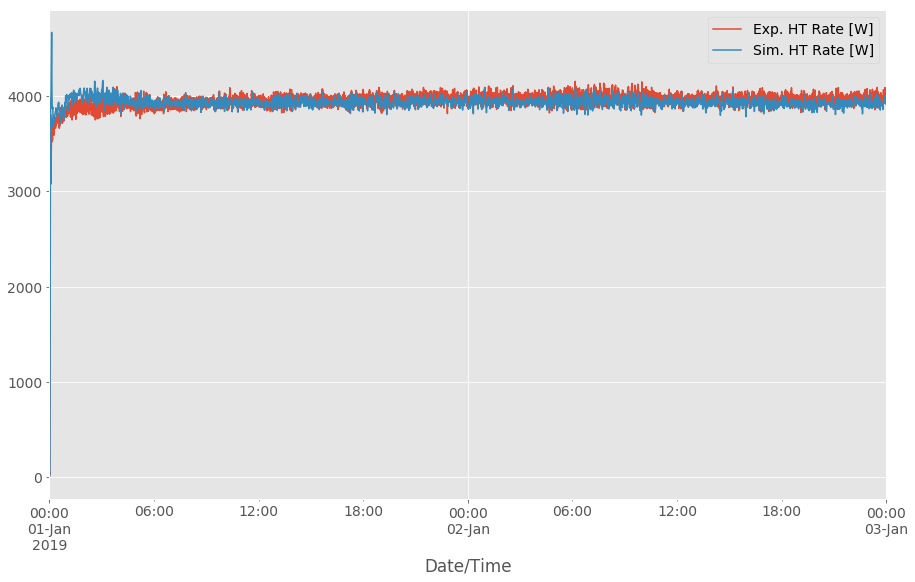

In [26]:
ax = df_sim_input_data[['HT Rate [W]']].rename(columns={'HT Rate [W]': 'Exp. HT Rate [W]'}).loc[df.index[0] : df.index[-1]].plot()
df[['GroundHeatExchanger:GHE 1:Heat Rate [W]']].rename(columns={'GroundHeatExchanger:GHE 1:Heat Rate [W]': 'Sim. HT Rate [W]'}).plot(grid=True, ax=ax)